Cosine Schedule

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [5]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [3]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>7: fc.defaults.cpus=7

### Load Dataset 

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
def collate_j(b):
    return [TF.to_tensor(o['image']) for o in b]

In [51]:
train_dl = DataLoader(dsd['train'], 512, collate_fn=collate_j)

In [52]:
data = next(iter(train_dl))

In [57]:
len(data), data[0].shape

(512, torch.Size([1, 28, 28]))

In [58]:
dstack = torch.stack(data, dim=0)

In [59]:
dstack.shape

torch.Size([512, 1, 28, 28])

In [60]:
dstack.mean(), dstack.std()

(tensor(0.2849), tensor(0.3526))

Clearly the mean and std deviation are not close to the 0.5, 1.0 that was anticipated

### Define functions for generating alphabar t and its inverse

In [6]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [72]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    # Note that torch.to will apply the type and device to the tensor
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    # Generate an image of random noise
    ε = torch.randn(x0.shape, device=device)
    # generate abar from the vector of t's and the abar function.
    # reshape so that it can broadcast over the batch
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    # Generate noised image from x0 and ε using abar_t. When t is zero
    # this will be x0, as t increased so the image tends to noise
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

### Generate dataloaders 

In [61]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [73]:
@inplace
def transformi(b):
    """ Transform to normalise the input.  In this case it is normalised to pad the image
    and then subtract 0.5.  This should result in a mean of zero and a standard deviation of 0.5, although
    since the dataset does not have the correct mean and sigma in the first place this will not be accurate
    """
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]
# Use the dataset with transform method to return data from the get item call using the defined transform
tds = dsd.with_transform(transformi)
# Create dataloader based upon the dataset with the transforms applied
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))

In [63]:
xt

tensor([[[[-0.4969, -0.9648, -0.3365,  ..., -0.0069, -0.5893, -1.0912],
          [ 0.2199, -0.9938, -0.9225,  ..., -1.4559, -0.1120, -0.3093],
          [-0.1668,  0.3929, -0.0063,  ..., -0.5420,  0.5084, -0.7664],
          ...,
          [-0.6749, -0.5417, -1.6198,  ...,  0.4970,  1.1262, -0.0413],
          [-1.0042, -0.8714,  0.4490,  ..., -0.9273, -0.1562, -0.1309],
          [-1.0190, -0.5094,  0.0061,  ..., -0.1277, -1.0604, -0.9104]]],


        [[[-0.8061, -0.2634, -0.7983,  ..., -1.4598, -1.2840, -1.3234],
          [ 0.0047, -0.1518,  0.4131,  ...,  0.2596, -0.6202,  0.0378],
          [-0.5912,  0.2680,  0.6090,  ...,  0.3607, -2.5501,  0.1102],
          ...,
          [ 0.5734, -0.6694, -0.6523,  ...,  0.5132,  0.1238, -0.2614],
          [-0.7621,  0.3057,  0.5560,  ..., -0.6419, -1.0298, -0.4757],
          [-1.5373, -1.6312, -1.2081,  ...,  0.3448, -0.4460,  0.0279]]],


        [[[-1.9199,  0.6638, -0.9063,  ...,  1.5501,  0.8457,  0.8676],
          [-1.6142,  1.271

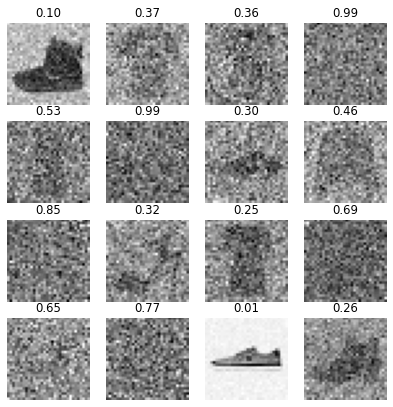

In [86]:
show_images(xt[:16], ncols=5, imsize=1.75, titles=fc.map_ex(t[:16], '{:.02f}'))

### Define model 

In [87]:
class Unet(UNet2DModel):
    """ Added as a wrapper since the Unet2dModel will return a dict, what we want is the sample
    item from that
    """
    def forward(self, x):
        super.forward(x.sample)

Init signature:
UNet2DModel(
    sample_size: Union[int, Tuple[int, int], NoneType] = None,
    in_channels: int = 3,
    out_channels: int = 3,
    center_input_sample: bool = False,
    time_embedding_type: str = 'positional',
    freq_shift: int = 0,
    flip_sin_to_cos: bool = True,
    down_block_types: Tuple[str] = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types: Tuple[str] = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels: Tuple[int] = (224, 448, 672, 896),
    layers_per_block: int = 2,
    mid_block_scale_factor: float = 1,
    downsample_padding: int = 1,
    act_fn: str = 'silu',
    attention_head_dim: int = 8,
    norm_num_groups: int = 32,
    norm_eps: float = 1e-05,
    resnet_time_scale_shift: str = 'default',
    add_attention: bool = True,
)
Source:        
class UNet2DModel(ModelMixin, ConfigMixin):
    r"""
    UNet2DModel is a 2D UNet model that takes in a noisy sample and a time

In [1]:
def init_ddpm(model):
    """ Zero the weights in all of the conv blocks in the downsample and upsample blocks
    """
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

### Create Learner 

In [ ]:
lr = 4e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

### Fit model

In [ ]:
learn.fit(epochs)


In [ ]:
torch.save(learn.model, 'models/fashion_cos.pkl')
model = learn.model = torch.load('models/fashion_cos.pkl').cuda()

### Examine output from the model 

Create a denoising function

In [2]:
def denoise(x_t, noise, t):
    device = x_t.device()
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    x0 = (x_t - (1.0 - abar_t.sqrt()) * noise) / abar_t.sqrt()
    return x0

In [ ]:
with torch.no_grad():
    noise = learn.model(xt.cuda(), t.cuda())

In [ ]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

In [ ]:
show_images(denoise(xt.cuda(),noise,t.cuda())[:25].clamp(-1,1), imsize=1.5, 
            titles=fc.map_ex(t[:25], '{:.02f}'))


### Sampling


In [ ]:
from miniai.fid import ImageEval

To compare generated images with real images it is necessary to use a trained classifier. 
In this case we will use the model trained with augmentation

In [8]:
cmodel = torch.load('/home/models/data_aug2.pkl')

# As before remove the last two layers to generate embeddings from the 6th block
del(cmodel[8])
del(cmodel[7])

# Define the same transforms as were used in model training
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

# Create image evaluator
ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
sz = (2048,1,32,32)
sz = (256,1,32,32)

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    """ If eta is 0 then the model is deterministic, if 1 then it is equal
    to DDPM.  The nomenclature is different to DDPM.  The code below follows the paper,
    the key thing being that in the equation eta(theta)(xt) gives the predicted noise from the model,
    which is passed in here as noise
    
    x_0_hat is the predicted final image and x_t is the prediction for the image at the next
    timestep
    
    """
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1.5,1.5)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

Note - plot x_t and x to see how much they change

In [ ]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    # Generate the timesteps
    ts = torch.linspace(1-1/steps,0,steps)
    # Create array of randome images
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        # Calculate abar for timestep
        abar_t = abar(t)
        # Generate noise from the model
        noise = model((x_t, t))
        # Calculate abar at t-1
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        # Apply sampling to generate predicted x0, x_t
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(),s.max(),s.shape

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s),s.shape

In [ ]:
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
ie.fid(preds[-1]*2)

In [ ]:
preds = sample(ddim_step, model, sz, steps=50, eta=1.)
ie.fid(preds[-1]*2)